In [145]:
# Standard import(s)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [146]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv1D, Conv1DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling1D, UpSampling1D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

In [147]:
def load_dataset():
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha + beta == 1:
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [148]:
X, y, file_index = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape)

Alpha, Beta is (0.2, 0.8) and given label 1
Alpha, Beta is (0.4, 0.6) and given label 2
Alpha, Beta is (0.6, 0.4) and given label 3
Alpha, Beta is (0.8, 0.2) and given label 4
(40000, 100)


In [149]:
X_train.shape[0]

40000

In [150]:
new_X_train = []
for i in range(X_train.shape[0]):
    new_X_train.append(np.array([X_train.iloc[i]]).T)
    
new_X_test = []
for i in range(X_test.shape[0]):
    new_X_test.append(np.array([X_test.iloc[i]]).T)

In [151]:
new_X_train = np.array(new_X_train)
new_X_test = np.array(new_X_test)

In [152]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [192]:
original_dim = 100
intermediate_dim = 75
intermediate_dim2 = 50
intermediate_dim3 = 25
latent_dim = 2

In [258]:
#inputs = Input((None, original_dim), name='input')
inputs = Input(shape=(original_dim, 1), name='input')

x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(inputs)
#x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)


# Flatten, ready for dense layers
x = Flatten()(x)
#x = Dense(2*latent_dim, activation='relu')(x)

# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [259]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_54 (Conv1D)              (None, 100, 16)      64          input[0][0]                      
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 100, 32)      1568        conv1d_54[0][0]                  
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 3200)         0           conv1d_55[0][0]                  
____________________________________________________________________________________________

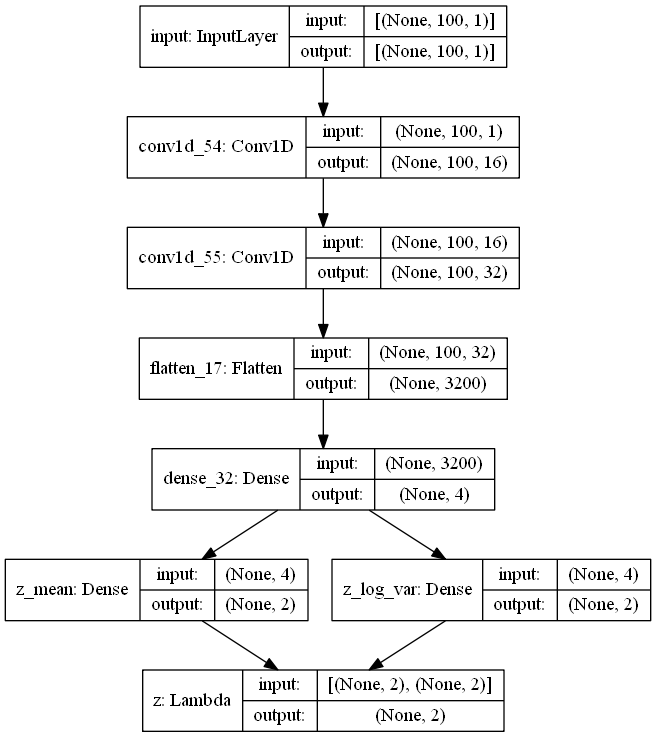

In [260]:
plot_model(encoder, show_shapes=True)

In [285]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = UpSampling1D(size=2)(latent_inputs)
#x = Dense(32*100, activation='relu')(latent_inputs)
x = Reshape((100, 32))(x)
x = Conv1DTranspose(16, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1DTranspose(32, kernel_size=3, padding='same', activation='relu')(x)
#x = UpSampling1D(size=2)(x)
outputs = Conv1DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

ValueError: Input 0 of layer up_sampling1d_17 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)

In [263]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 3200)              9600      
_________________________________________________________________
reshape_19 (Reshape)         (None, 100, 32)           0         
_________________________________________________________________
conv1d_transpose_37 (Conv1DT (None, 100, 16)           1552      
_________________________________________________________________
conv1d_transpose_38 (Conv1DT (None, 100, 32)           1568      
_________________________________________________________________
conv1d_transpose_39 (Conv1DT (None, 100, 1)            97        
Total params: 12,817
Trainable params: 12,817
Non-trainable params: 0
_______________________________________________________

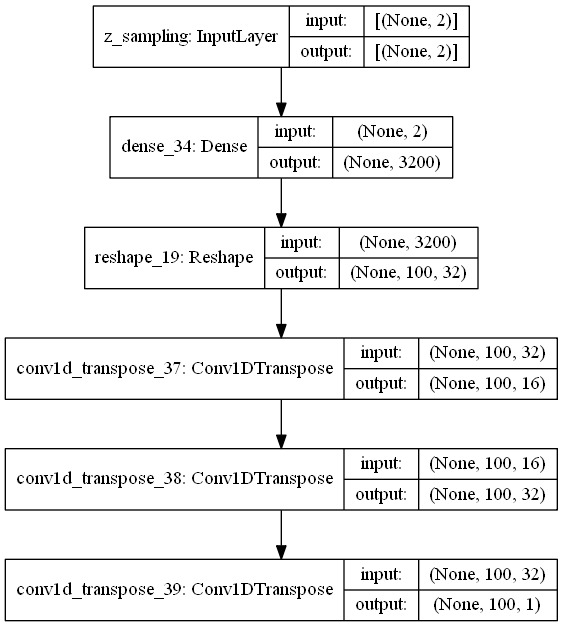

In [264]:
plot_model(decoder, show_shapes=True)

In [265]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [266]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 1)]          0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 14456     
_________________________________________________________________
decoder (Functional)         (None, 100, 1)            12817     
Total params: 27,273
Trainable params: 27,273
Non-trainable params: 0
_________________________________________________________________


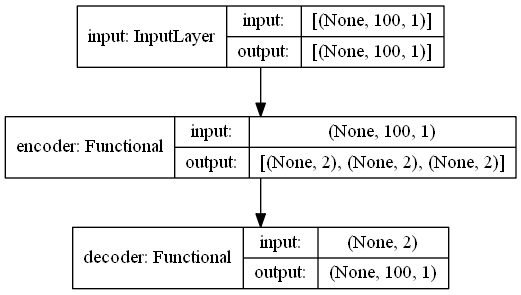

In [267]:
plot_model(vae, show_shapes=True)

In [268]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [269]:
# Define parameters
nb_epochs  =  10
batch_size = 100

In [270]:
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)

vae_history = vae.fit(new_X_train, new_X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 9s 282us/sample - loss: 5955.6712 - reco_loss: 5936.5122 - kl_loss: 19.1577 - val_loss: 5813.9754 - val_reco_loss: 5798.4312 - val_kl_loss: 15.5436
Epoch 2/10
32000/32000 [==============================] - 8s 264us/sample - loss: 5800.8291 - reco_loss: 5786.4878 - kl_loss: 14.3399 - val_loss: 5803.7938 - val_reco_loss: 5791.0674 - val_kl_loss: 12.7272
Epoch 3/10
32000/32000 [==============================] - 7s 231us/sample - loss: 5794.0936 - reco_loss: 5782.0732 - kl_loss: 12.0195 - val_loss: 5800.5141 - val_reco_loss: 5789.3213 - val_kl_loss: 11.1921
Epoch 4/10
32000/32000 [==============================] - 6s 194us/sample - loss: 5790.9961 - reco_loss: 5780.1260 - kl_loss: 10.8703 - val_loss: 5803.1694 - val_reco_loss: 5792.9580 - val_kl_loss: 10.2119
Epoch 5/10
32000/32000 [==============================] - 9s 270us/sample - loss: 5788.4026 - reco_loss: 5778.2349 - kl_loss: 1

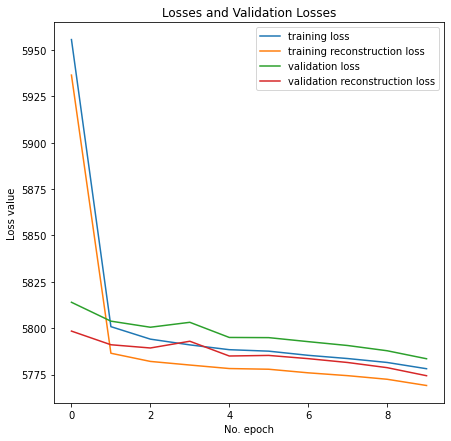

In [271]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
#plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
#plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [272]:
z_mean, _, _ = encoder.predict(new_X_test)

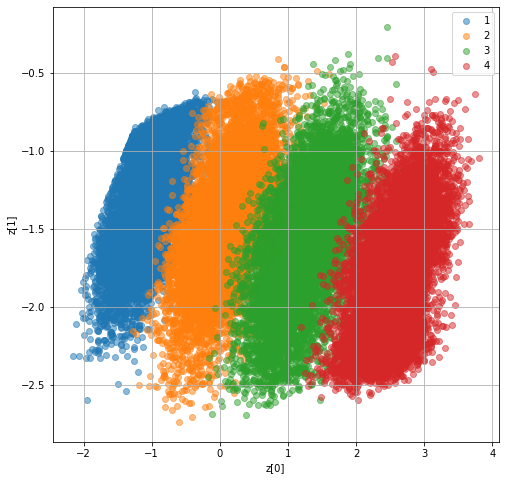

In [273]:
# Create figure and axis objects.
fig, ax = plt.subplots(figsize=(8,8))
# Loop for each digit label
for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current digit on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               single_label[:, 1],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space for next part clear
ax.grid()
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

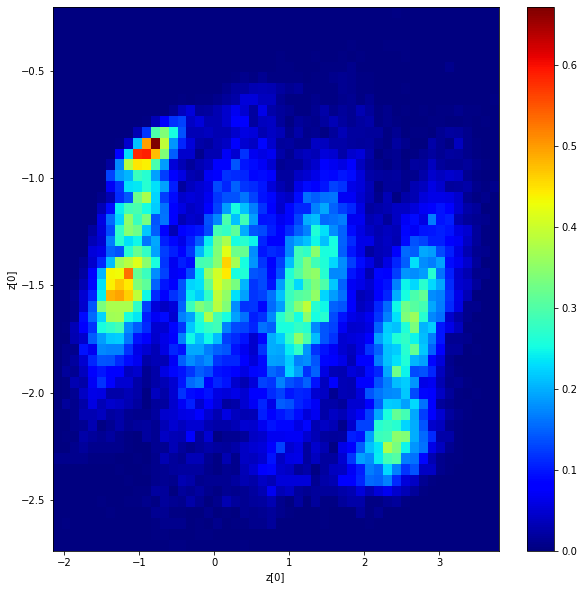

In [274]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(z_mean[:, 0], z_mean[:, 1], bins=50, density=True, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('z[0]')
plt.ylabel('z[0]')

plt.show()

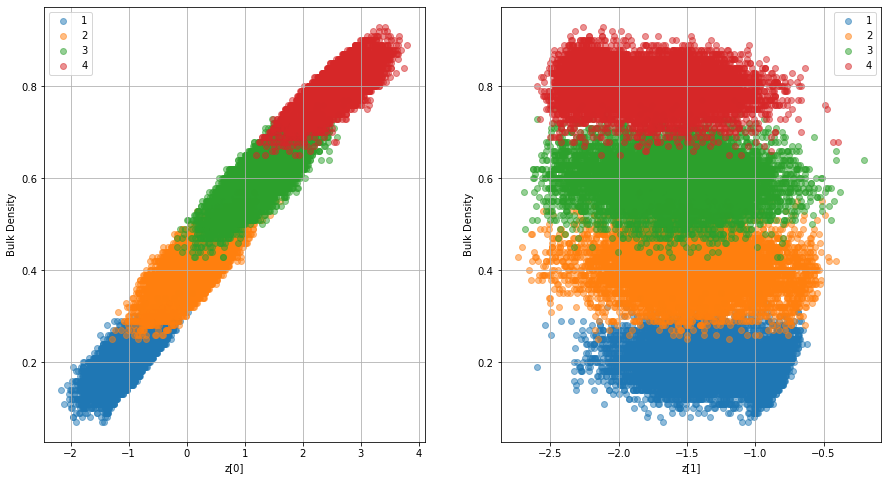

In [275]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    ax[1].scatter(single_label[:, 1],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax[0].legend()
# Include grid lines to make chosen region of latent space clear
ax[0].grid()
ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Bulk Density')
# Draw legend
ax[1].legend()
# Include grid lines to make chosen region of latent space clear
ax[1].grid()
ax[1].set_xlabel('z[1]')
ax[1].set_ylabel('Bulk Density')

plt.show()

In [276]:
"""fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Bulk Density')

plt.show()"""

"fig, ax = plt.subplots(1,1,figsize=(8,8))\n\nfor t in range(1, file_index):\n    # Boolean mask\n    mask = y_test == t\n    # Scatter plot for current point on same axes as the rest\n    single_label = z_mean[mask]\n    ax.scatter(single_label[:, 0],\n               np.mean(X_test[mask], axis=1),\n               label=t, alpha=0.5)\n    pass\n\n# Draw legend\nax.legend()\n# Include grid lines to make chosen region of latent space clear\nax.grid()\nax.set_xlabel('z')\nax.set_ylabel('Bulk Density')\n\nplt.show()"

In [277]:
X_test_currents = []
for i in range(len(X_test)):
    jumps_possible = 0
    occs = np.array(X_test.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    X_test_currents.append(jumps_possible / len(occs))
    
X_test_currents = np.array(X_test_currents)

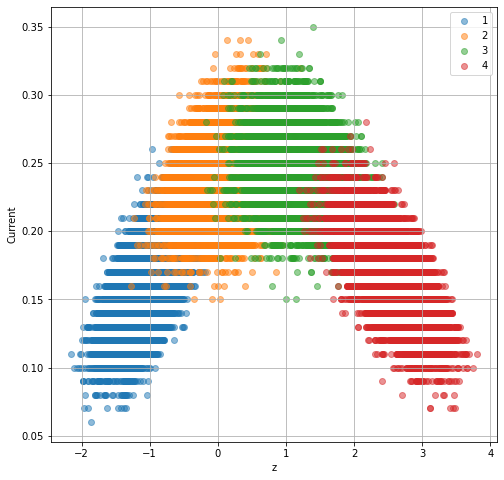

In [278]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               X_test_currents[mask],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space clear
ax.grid()
ax.set_xlabel('z')
ax.set_ylabel('Current')

plt.show()

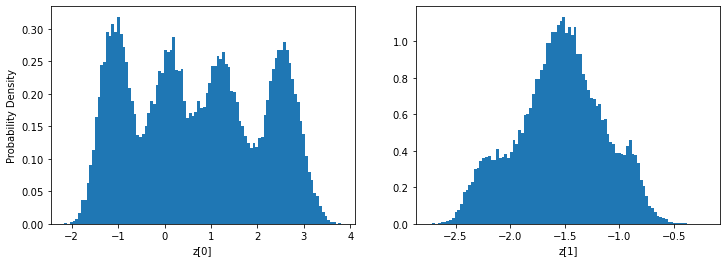

In [279]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
# Make histogram at the 
ax[0].hist(z_mean[:, 0],bins=100, density=True)
ax[1].hist(z_mean[:, 1],bins=100, density=True)

ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Probability Density')
ax[1].set_xlabel('z[1]')

plt.show()

In [280]:
"""fig, ax = plt.subplots(1,1,figsize=(8,6))
# Make histogram at the 
ax.hist(z_mean[:, 0],bins=100, density=True)

ax.set_xlabel('z')
ax.set_ylabel('Probability Density')

plt.show()"""

"fig, ax = plt.subplots(1,1,figsize=(8,6))\n# Make histogram at the \nax.hist(z_mean[:, 0],bins=100, density=True)\n\nax.set_xlabel('z')\nax.set_ylabel('Probability Density')\n\nplt.show()"

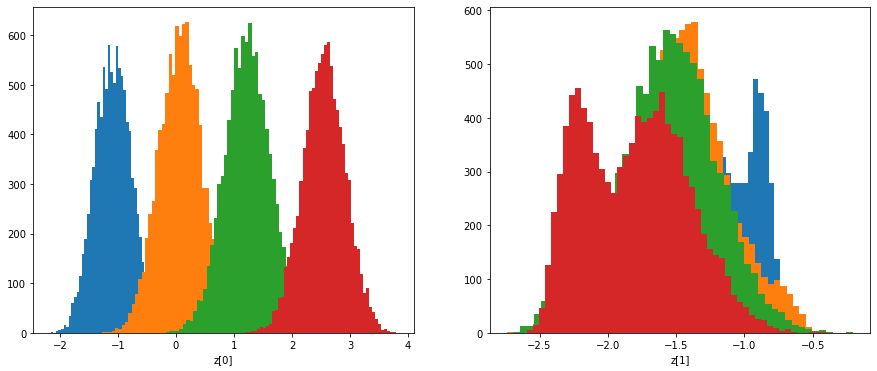

In [281]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].hist(single_label[:, 0],
               bins=50)
    ax[1].hist(single_label[:, 1],
               bins=50)
    pass

ax[0].set_xlabel('z[0]')
ax[1].set_xlabel('z[1]')

plt.show()

In [282]:
"""fig, ax = plt.subplots(1,1,figsize=(8,6))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax.hist(single_label[:, 0],
               bins=50)
    pass

ax.set_xlabel('z')

plt.show()"""

"fig, ax = plt.subplots(1,1,figsize=(8,6))\n\nfor t in range(1, file_index):\n    # Boolean mask\n    mask = y_test == t\n    # Scatter plot for current point on same axes as the rest\n    single_label = z_mean[mask]\n    ax.hist(single_label[:, 0],\n               bins=50)\n    pass\n\nax.set_xlabel('z')\n\nplt.show()"

In [283]:
"""# Size of line segments in latent space
one_start = -1.6
one_stop = -1.1
two_start = -0.8
two_stop = -0.3
three_start = 0.2
three_stop = 0.7
four_start = 1.1
four_stop = 1.6
# How many points per segment
num_pts = 
z0_pts_line = np.linspace(z0_start, z0_stop, num_pts)
z1_pts_line = np.linspace(z1_start, z1_stop, num_pts)
z0s, z1s = np.meshgrid(z0_pts_line, z1_pts_line)
z0s = z0s.flatten()
z1s = z1s.flatten()
zs = np.empty([num_pts**2, 2])
# Pair up the x and y points to give list of grid coordinates
for i in range(len(z1s)):
    zs[i] = z0s[i], z1s[i]"""

'# Size of line segments in latent space\none_start = -1.6\none_stop = -1.1\ntwo_start = -0.8\ntwo_stop = -0.3\nthree_start = 0.2\nthree_stop = 0.7\nfour_start = 1.1\nfour_stop = 1.6\n# How many points per segment\nnum_pts = \nz0_pts_line = np.linspace(z0_start, z0_stop, num_pts)\nz1_pts_line = np.linspace(z1_start, z1_stop, num_pts)\nz0s, z1s = np.meshgrid(z0_pts_line, z1_pts_line)\nz0s = z0s.flatten()\nz1s = z1s.flatten()\nzs = np.empty([num_pts**2, 2])\n# Pair up the x and y points to give list of grid coordinates\nfor i in range(len(z1s)):\n    zs[i] = z0s[i], z1s[i]'

In [284]:
type_ones = np.array([[-1.0, -1.0], [2.5, 0.0], [2.5, -0.5], [2.5, -1.0]])
decoder.predict(np.array([type_ones[0]]))

array([[[0.18755355],
        [0.1719934 ],
        [0.18979293],
        [0.19165167],
        [0.1870322 ],
        [0.17380765],
        [0.17934242],
        [0.1812559 ],
        [0.18491521],
        [0.2111201 ],
        [0.21363527],
        [0.21140173],
        [0.20010543],
        [0.16956383],
        [0.15872696],
        [0.17217639],
        [0.18381155],
        [0.18192247],
        [0.18435743],
        [0.18599787],
        [0.19552991],
        [0.2077136 ],
        [0.19799274],
        [0.18696976],
        [0.19643098],
        [0.2058669 ],
        [0.2097964 ],
        [0.19129416],
        [0.17663643],
        [0.17663768],
        [0.18742517],
        [0.18012962],
        [0.18619692],
        [0.18957505],
        [0.19915712],
        [0.20478651],
        [0.19949836],
        [0.19294807],
        [0.18789136],
        [0.18105432],
        [0.16980588],
        [0.18481782],
        [0.18764427],
        [0.17922744],
        [0.15304917],
        [0

In [180]:
"""zs = np.array([-1.3, -0.4, 0.4, 1.3])
nb_show = 4
fig, ax = plt.subplots(1,1,figsize=(10,6))
for i in range(nb_show):
    ax.scatter(list(range(100)), decoder.predict(np.array([zs[i]])))
    ax.set_ylim(0, 1)
    ax.set_xlabel('site')
    ax.set_ylabel('Density')
plt.show()"""

"zs = np.array([-1.3, -0.4, 0.4, 1.3])\nnb_show = 4\nfig, ax = plt.subplots(1,1,figsize=(10,6))\nfor i in range(nb_show):\n    ax.scatter(list(range(100)), decoder.predict(np.array([zs[i]])))\n    ax.set_ylim(0, 1)\n    ax.set_xlabel('site')\n    ax.set_ylabel('Density')\nplt.show()"